# Dataset Overview: Description of Source, Variables, and Time Period

The dataset used for this project focuses on **electricity production**, specifically represented by the variable **EP** (originally labeled as `IPG2211A2N`). The data is recorded on a **monthly basis**, spanning from **January 1985 to January 2018**.

The dataset was sourced from Kaggle:  
[Time Series Datasets – Kaggle](https://www.kaggle.com/datasets/shenba/time-series-datasets/data)


For this analysis, the variable `IPG2211A2N` has been renamed to **EP** (Electricity Production) for ease of reference throughout the project.

---

## 1. Data Collection & Preprocessing

### 1.1 Importing Libraries & Loading Dataset

In this section, we import the necessary Python libraries for time series analysis and machine learning. We then load the **Electric Production** dataset, convert the `DATE` column to datetime format, and set it as the index to prepare for time series operations. We also keep only the target variable (`EP`) and inspect the dataset.


In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
# Dataset Path
file_path="C:\\Users\\moham\\Desktop\\Electric_Production.csv"
# Load dataset
df = pd.read_csv(file_path)
# Convert DATE column to datetime and set it as index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
# Keep only the electricity production column
df = df['EP']
# Preview the data
print(df.head())
print(df.info()) # Check for basic information about the dataset (number of rows, columns, datatypes)

DATE
1985-01-01    72.5052
1985-02-01    70.6720
1985-03-01    62.4502
1985-04-01    57.4714
1985-05-01    55.3151
Name: EP, dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Series name: EP
Non-Null Count  Dtype  
--------------  -----  
397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB
None


### 1.2 Visualizing the Time Series

We plot the monthly electricity production over time to observe general trends, seasonal patterns, and any anomalies. This visualization helps build an initial understanding of the data’s behavior.


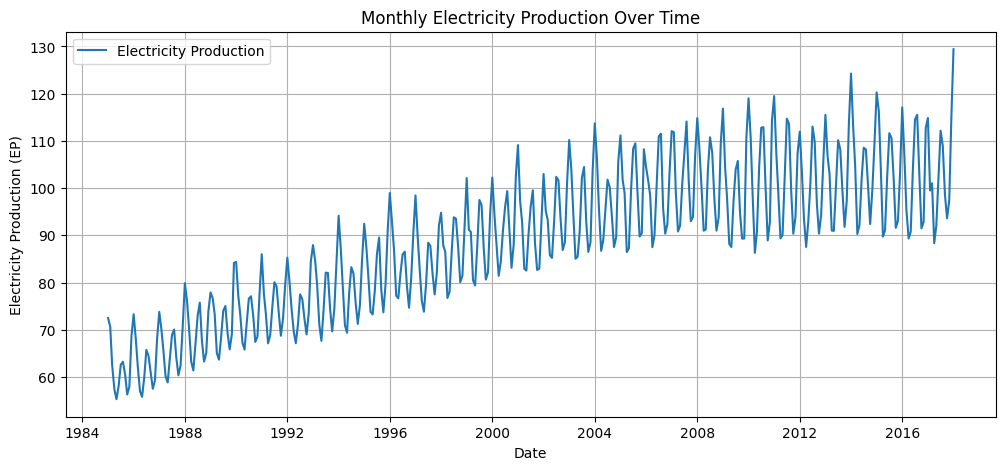

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(df, label='Electricity Production')
plt.title('Monthly Electricity Production Over Time')
plt.xlabel('Date')
plt.ylabel('Electricity Production (EP)')
plt.legend()
plt.grid(True)
plt.show()

### 1.3 Data Cleaning: Missing Values, Outliers, and Duplicates

In this section, we handle key data quality issues:

- **Missing Values**: We check for any null values in the dataset.
- **Outliers**: We apply the Interquartile Range (IQR) method to detect and remove outliers, which can skew model performance.
- **Duplicates**: We identify and drop any duplicate entries to ensure data integrity.

A side-by-side plot is generated to visually compare the original dataset with the cleaned version.


Number of missing values: 0
Number of outliers removed: 0
Number of duplicate rows: 0


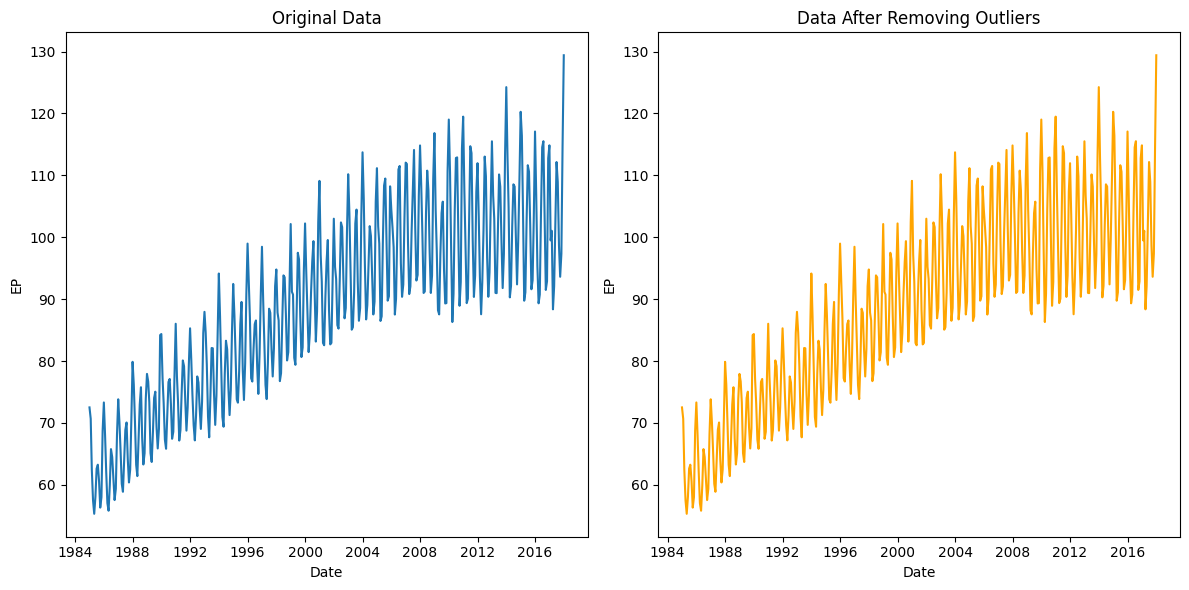

In [9]:
#----Handling Missing Values:----#

# Check for missing values
print(f"Number of missing values: {df.isnull().sum()}")
#---- Handling Outliers ----#
# Calculate IQR (Interquartile Range) for outlier detection
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
# Define the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out outliers
df_clean = df[(df >= lower_bound) & (df <= upper_bound)]
# Show the number of outliers removed
outliers_removed = len(df) - len(df_clean)
print(f'Number of outliers removed: {outliers_removed}')
#########################################################################
#---- Handling Duplicated values ----#

# Check for duplicate rows in the dataset
duplicate_rows = df.duplicated().sum()
# Print the message along with the number of duplicate rows
print(f"Number of duplicate rows: {duplicate_rows}")
# Remove duplicate rows if any
df = df.drop_duplicates()
# Compare the original and cleaned data visually
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(df, label='Original Data')
plt.title('Original Data')
plt.xlabel('Date')
plt.ylabel('EP')
plt.subplot(1, 2, 2)
plt.plot(df_clean, label='Cleaned Data', color='orange')
plt.title('Data After Removing Outliers')
plt.xlabel('Date')
plt.ylabel('EP')
plt.tight_layout()
plt.show()


### 1.4 Feature Engineering for Time Series Regression

We prepare the dataset for regression modeling by engineering time-based features:

- **Month, Year, Quarter**: Extracted from the datetime index to capture seasonal and annual trends.
- **TimeIndex**: A numeric trend feature representing the time progression.
- **Cyclical Encoding**: `Month` is encoded using sine and cosine transformations to reflect its cyclical nature (e.g., January and December are close in time).

These features enhance the model's ability to learn patterns from temporal structure in the data.


In [11]:
# Create a new DataFrame for regression modeling
df_reg = df.copy().to_frame()  # Ensure df is converted from Series to DataFrame

# Time-based feature extraction
df_reg['Month'] = df_reg.index.month
df_reg['Year'] = df_reg.index.year
df_reg['Quarter'] = df_reg.index.quarter
df_reg['TimeIndex'] = np.arange(len(df_reg)) # Trend feature (e.g., simple index over time)
# Cyclical encoding of Month
df_reg['Month_sin'] = np.sin(2 * np.pi * df_reg['Month'] / 12)
df_reg['Month_cos'] = np.cos(2 * np.pi * df_reg['Month'] / 12)

# Preview the updated dataset
df_reg.head()


,EP,Month,Year,Quarter,TimeIndex,Month_sin,Month_cos
DATE,,,,,,,
1985-01-01,72.5052,1,1985,1,0,0.500000,8.660254e-01
1985-02-01,70.6720,2,1985,1,1,0.866025,5.000000e-01
1985-03-01,62.4502,3,1985,1,2,1.000000,6.123234e-17
1985-04-01,57.4714,4,1985,2,3,0.866025,-5.000000e-01
1985-05-01,55.3151,5,1985,2,4,0.500000,-8.660254e-01


## 2. Exploratory Data Analysis (EDA)

### 2.1 Descriptive Statistics

We compute key descriptive statistics to summarize the distribution of the electricity production data:

- **Basic Stats**: Count, mean, standard deviation, min, max, and quartiles.
- **Skewness**: Measures asymmetry of the distribution. A value ≠ 0 indicates skewed data.
- **Kurtosis**: Measures the "tailedness" of the distribution. High kurtosis suggests heavy tails or outliers.

These metrics provide insight into the shape and spread of the time series.


In [14]:
# Descriptive statistics
desc_stats = df.describe()
skewness = df.skew()
kurtosis = df.kurt()

# Display all together
print("Descriptive Statistics:")
print(desc_stats)
print("\nSkewness:", skewness)
print("Kurtosis:", kurtosis)

Descriptive Statistics:
count    397.000000
mean      88.847218
std       15.387834
min       55.315100
25%       77.105200
50%       89.779500
75%      100.524400
max      129.404800
Name: EP, dtype: float64

Skewness: -0.07309562446039364
Kurtosis: -0.6942008809310036


### 2.2 Time Series Analysis of Electricity Production

This section provides a series of visualizations and statistical techniques to analyze electricity production over time. Below are the key sections:

#### 1. Histogram with Kernel Density Estimate (KDE)
In this section, a histogram is used to visualize the distribution of electricity production values in the dataset. A Kernel Density Estimate (KDE) is overlaid on the histogram to provide a smoother representation of the data’s distribution, helping to identify patterns such as skewness or multimodality.

#### 2. Box Plot
A boxplot is created to visualize the spread of electricity production values. This plot displays the median, quartiles, and potential outliers in the data, offering insights into the range and variability of electricity production, as well as any extreme values that deviate from the overall distribution.

#### 3. Rolling Mean and Standard Deviation
This section calculates and visualizes the rolling mean and rolling standard deviation of electricity production over a 12-month window. The rolling mean helps smooth the time series data, revealing long-term trends, while the rolling standard deviation provides a sense of the variability or volatility in the data. The plot features two y-axes to display both the rolling mean and rolling standard deviation, offering a comprehensive view of the time series behavior.


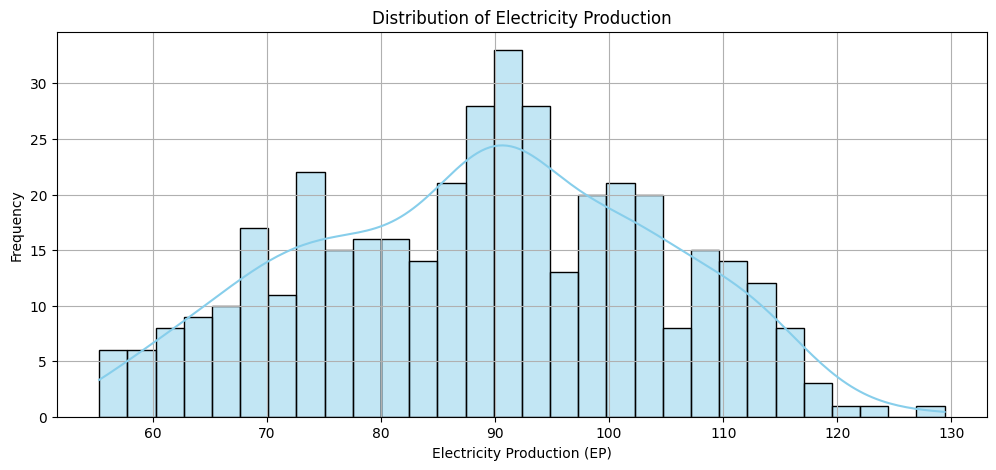

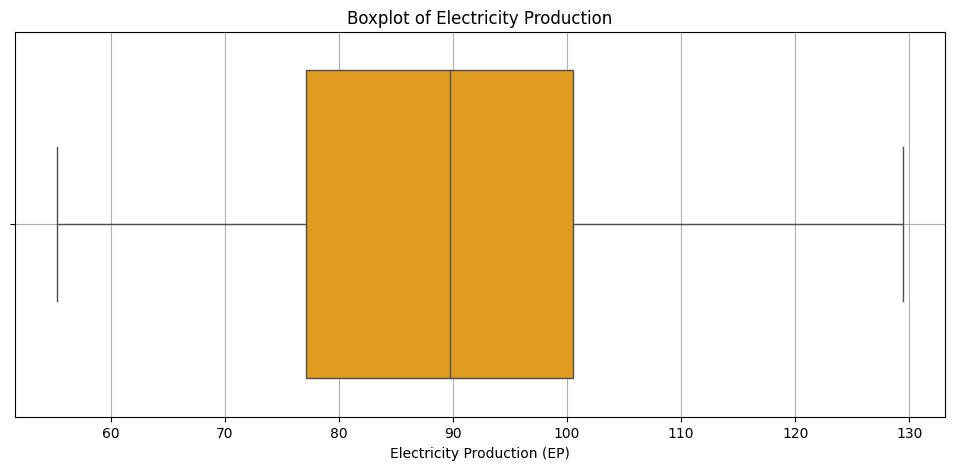

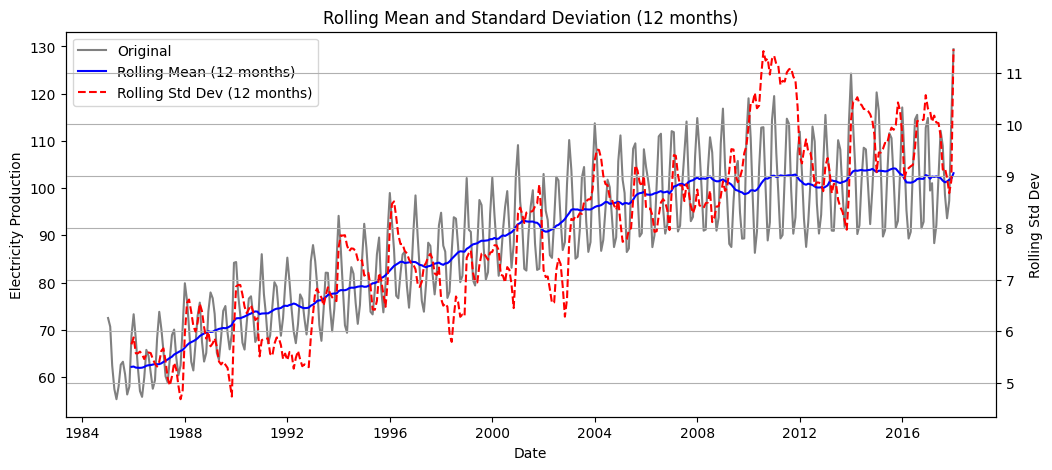

In [16]:
# 1-Histogram with KDE
plt.figure(figsize=(12, 5))
sns.histplot(df, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Electricity Production')
plt.xlabel('Electricity Production (EP)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2-Box Plot
plt.figure(figsize=(12, 5))
sns.boxplot(x=df, color='orange')
plt.title('Boxplot of Electricity Production')
plt.xlabel('Electricity Production (EP)')
plt.grid(True)
plt.show()

# 3-Rolling Mean and Standard Deviation

fig, ax1 = plt.subplots(figsize=(12, 5))

# Compute rolling mean and rolling standard deviation (12-month window)
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()
ax1.plot(df, label='Original', color='gray')
ax1.plot(rolling_mean, label='Rolling Mean (12 months)', color='blue')
ax1.set_ylabel('Electricity Production')
ax1.set_xlabel('Date')

# Create second y-axis for rolling std dev
ax2 = ax1.twinx()
ax2.plot(rolling_std, label='Rolling Std Dev (12 months)', color='red', linestyle='--')
ax2.set_ylabel('Rolling Std Dev')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')
plt.title('Rolling Mean and Standard Deviation (12 months)')
plt.grid(True)
plt.show()



### 2.3 Additive Seasonal Decomposition

In this section, we perform an additive seasonal decomposition of the time series data. The additive model assumes that the observed time series is the sum of three components: the trend, the seasonal variation, and the residuals (noise). The decomposition is based on a 12-month period, reflecting yearly seasonal patterns. The plot visualizes these components, helping to better understand the underlying trends, seasonal effects, and random fluctuations in electricity production.


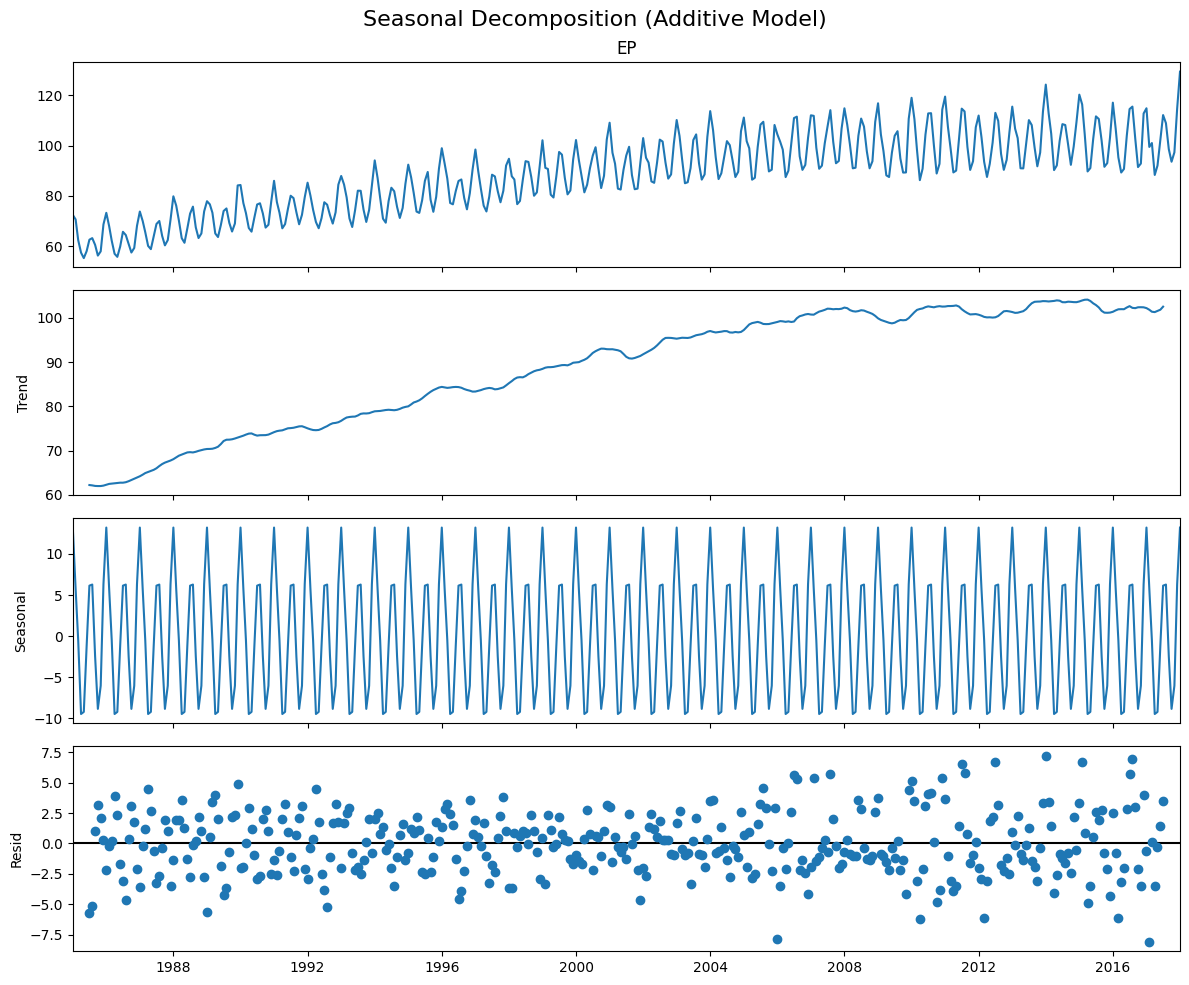

In [18]:
# Perform additive decomposition
decomposition = seasonal_decompose(df, model='additive', period=12)

# Plot the decomposition
plt.rcParams.update({'figure.figsize': (12, 10)})
decomposition.plot()
plt.suptitle('Seasonal Decomposition (Additive Model)', fontsize=16)
plt.tight_layout()
plt.show()


### 2.4 Data Visualizations

In this section, we explore the structure and distribution of the electricity production data:

1. **Line Plot**: Visualizes the trend of electricity consumption over time.
2. **Histogram & Box Plot**: 
   - The histogram shows the frequency distribution of values.
   - The box plot highlights the spread and presence of outliers.
3. **Correlation Heatmap**: Displays the relationships between the engineered time-based features and electricity production, helping identify potential predictors for modeling.


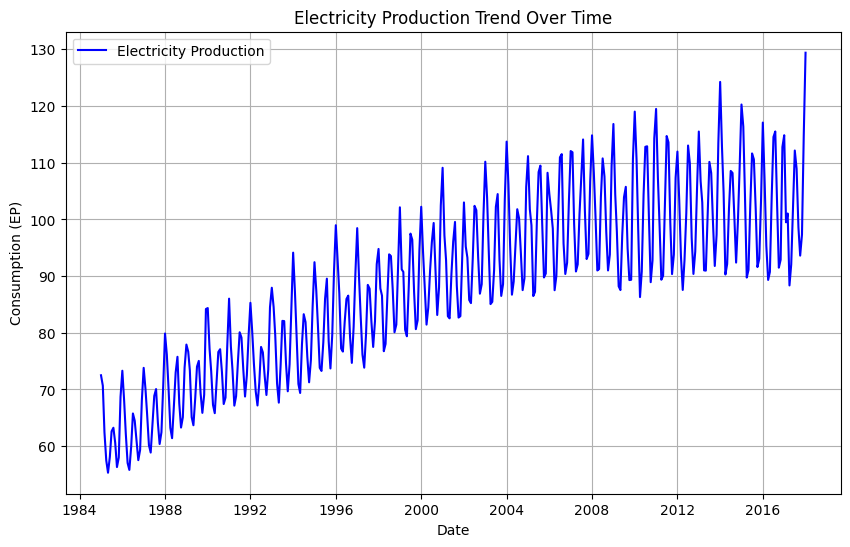

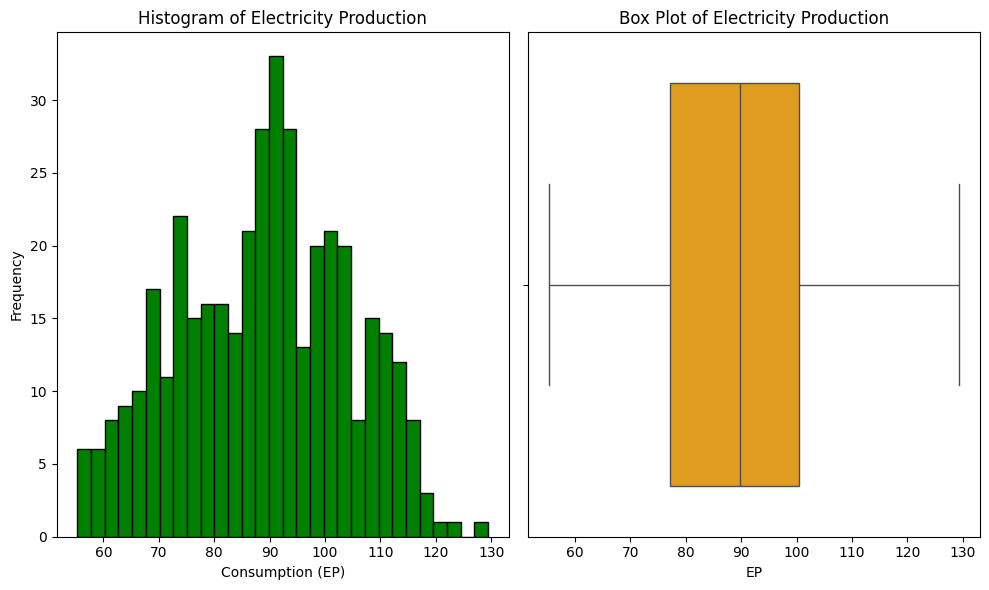

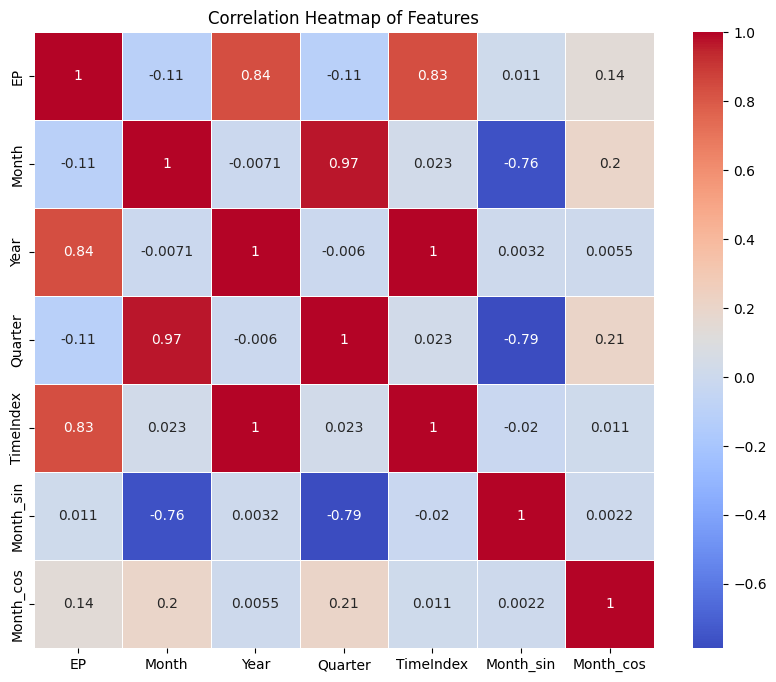

In [20]:


# 1. Line Plot: Trend over time
plt.figure(figsize=(10, 6))
plt.plot(df, label='Electricity Production', color='b')
plt.title('Electricity Production Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption (EP)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Histogram and Box Plot: Distribution of the target variable
plt.figure(figsize=(10, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(df, bins=30, color='g', edgecolor='black')
plt.title('Histogram of Electricity Production')
plt.xlabel('Consumption (EP)')
plt.ylabel('Frequency')

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(x=df, color='orange')
plt.title('Box Plot of Electricity Production')

plt.tight_layout()
plt.show()

# 3. Correlation Heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(df_reg.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

## 3. Model 1: ARIMA, SARIMA & Auto ARIMA

In this section, we apply and compare different time series forecasting models:

- **Stationarity Testing**: Check if the series is stationary and apply transformations if necessary.
- **Train-Test Split**: Divide the dataset for model training and evaluation.
- **Auto ARIMA**: Automatically determine the best `(p, d, q)` and seasonal `(P, D, Q, s)` parameters using AIC/BIC minimization.
- **ARIMA Model**: Fit an ARIMA model for non-seasonal forecasting.
- **SARIMA Model**: Fit a SARIMA model to capture both trend and seasonal patterns in the data.


### 3.1 Stationarity Check: Augmented Dickey-Fuller (ADF) Test

To determine whether the time series is stationary (i.e., its statistical properties do not change over time), we apply the **Augmented Dickey-Fuller (ADF) test**:

- **Null Hypothesis (H₀)**: The series has a unit root (non-stationary).
- **Alternative Hypothesis (H₁)**: The series is stationary.

We evaluate the **ADF statistic**, **p-value**, and **critical values**. A p-value less than 0.05 typically indicates that we can reject the null hypothesis and conclude the series is stationary.


In [23]:
#stationary check 
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')

# Original series ADF test
print("Original Series ADF Test:")
adf_test(df)

Original Series ADF Test:
ADF Statistic: -2.2569903500472432
p-value: 0.18621469116586814
Critical Values: {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}


### 3.2 Stationarity Check After Differencing

Since the original series may not be stationary, we apply **differencing** to make it stationary:

- **Differencing**: Subtract the previous observation from the current one (`df.diff()`).
- We then reapply the **Augmented Dickey-Fuller (ADF) test** to check if the differenced series is stationary.

A stationary series is necessary for effective ARIMA modeling.


In [25]:
# Differenced series ADF test
diff_df = df.diff().dropna()
print("\nDifferenced Series ADF Test:")
adf_test(diff_df)


Differenced Series ADF Test:
ADF Statistic: -7.10489088226736
p-value: 4.0777865655383114e-10
Critical Values: {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}


### 3.3 Autocorrelation Plots: ACF for Differenced and Original Data

We create and display the **Autocorrelation Function (ACF)** plots for both the **differenced** and **original** time series data to analyze the correlation between observations at different lags.

1. **ACF Plot for Differenced Data**  
   - First, we plot the ACF of the **differenced data** (`diff_df`) to assess the correlation of residuals after removing trends and seasonality.
   - The ACF plot helps to determine whether there is still autocorrelation remaining that might require additional differencing or transformation.

2. **ACF Plot for Original Data**  
   - Next, we plot the ACF of the **original data** (`df`) to observe how the raw time series behaves in terms of autocorrelation at different lags.
   - This plot provides insight into potential seasonality and patterns that could inform modeling decisions.

Both plots are displayed with a lag of 50 to capture longer-term dependencies and autocorrelation structure.


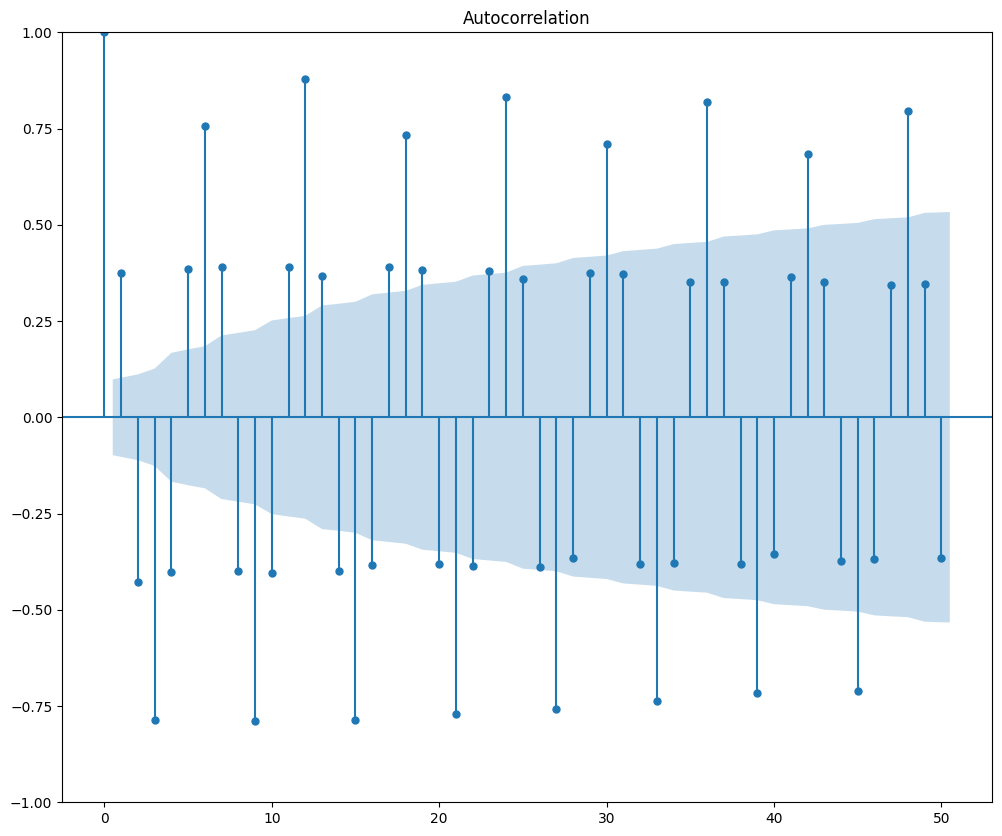

<Figure size 1200x1000 with 0 Axes>

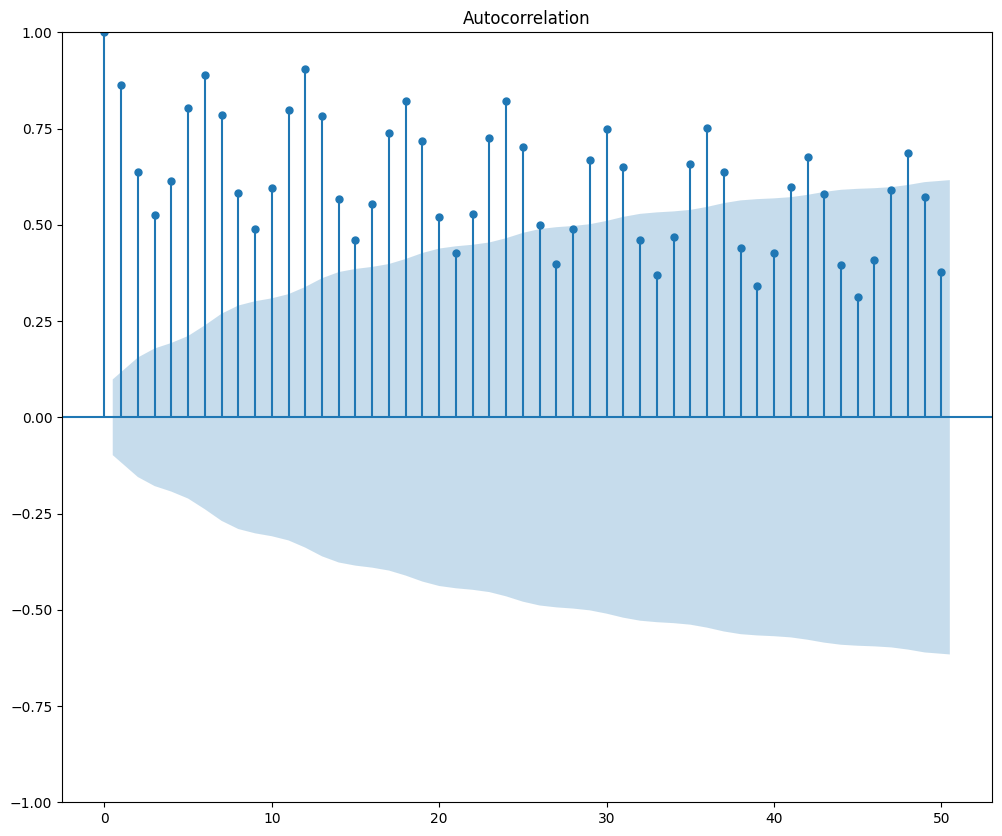

<Figure size 1200x1000 with 0 Axes>

In [27]:
plot_acf(diff_df, lags=50,)
plt.show()
plt.tight_layout()

plot_acf(df, lags=50,)
plt.show()
plt.tight_layout()

### 3.4 Model Training:  Auto ARIMA

In this section, we perform the following steps:

1. **Train-Test Split**: 
   We split the data into training (80%) and testing (20%) sets to evaluate model performance.
   
2. **Auto ARIMA**: 
   We use the `pmdarima.auto_arima()` function to automatically find the best ARIMA and seasonal parameters `(p, d, q)` and `(P, D, Q, s)` based on AIC/BIC minimization.

3. **Parameter Extraction**: 
   We extract and display the optimal ARIMA parameters (non-seasonal) and SARIMA parameters (seasonal) for model fitting.


In [29]:


# Define the split point (80% train, 20% test)
split_index = int(len(df) * 0.80)

# Split the data for ARIMA (train-test)
train_arima = diff_df.iloc[:split_index]
test_arima = diff_df.iloc[split_index:]


# AutoARIMA to find the best ARIMA parameters
auto_arima_model = pm.auto_arima(train_arima, seasonal=True, m=12, stepwise=True, trace=True)


# Get the best ARIMA parameters from AutoARIMA
print("Best ARIMA parameters from AutoARIMA:")
print(auto_arima_model.summary())

# Extract the ARIMA parameters
p, d, q = auto_arima_model.order  # (p, d, q)
P, D, Q, s = auto_arima_model.seasonal_order  # (P, D, Q, s)

# Display the selected parameters
print(f"ARIMA(p, d, q) = ({p}, {d}, {q})")
print(f"SARIMA(P, D, Q, s) = ({P}, {D}, {Q}, {s})")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1361.918, Time=1.46 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1540.366, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1478.602, Time=0.18 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1404.335, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1538.368, Time=0.04 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=1360.132, Time=1.34 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=1362.136, Time=2.30 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=1362.233, Time=3.13 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1359.590, Time=1.03 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=1361.434, Time=1.18 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=1361.350, Time=2.16 sec
 ARIMA(1,0,2)(1,1,0)[12] intercept

####  Model Diagnostics: Evaluating Residuals

We evaluate the diagnostic plots of the **Auto ARIMA** model to check the validity of model assumptions:

- **Residual Analysis**: The residuals should resemble white noise (i.e., no patterns), with constant variance and zero mean.
- **Plots**: These include autocorrelation of residuals, histogram, and QQ-plot to ensure the residuals are normally distributed and independent.

This step is crucial for verifying the quality and robustness of the model's predictions.


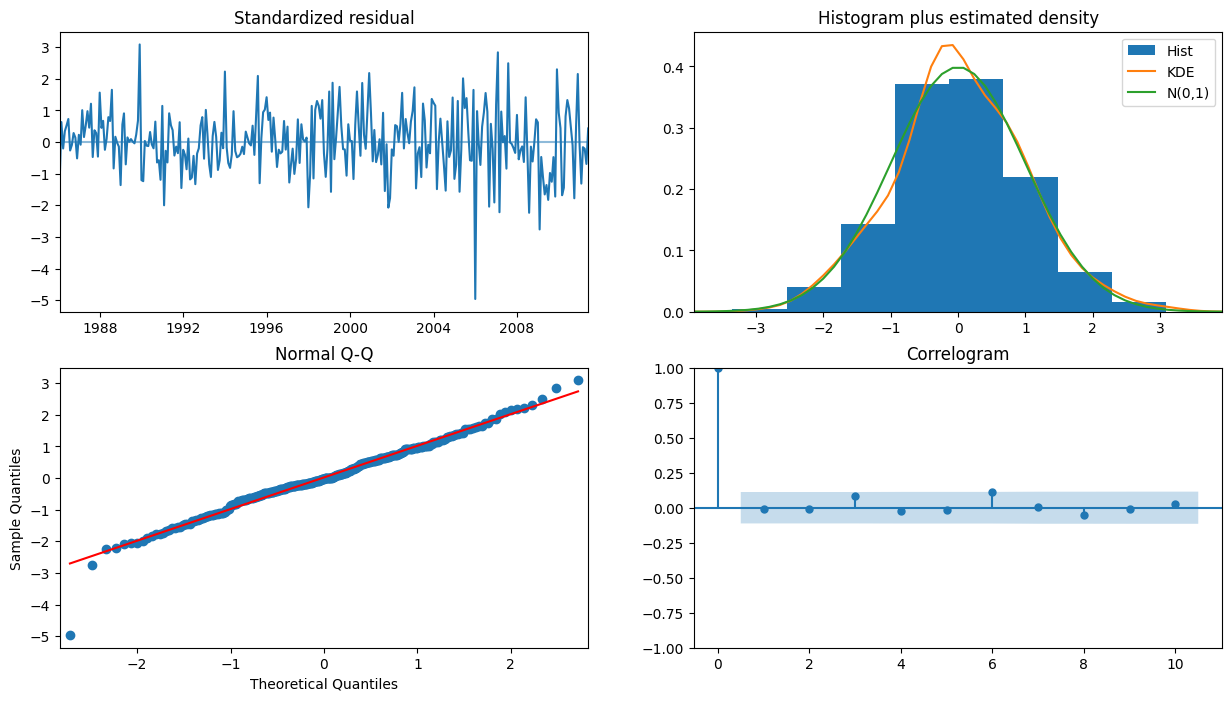

In [31]:
# plotting diagnostics to evaluate model assumptions and residual behavior
auto_arima_model.plot_diagnostics(figsize=(15,8))  
plt.show()

### 3.5 ARIMA Model: Forecasting and Evaluation

In this section, we:

1. **Fit the ARIMA Model**: 
   We use the parameters obtained from Auto ARIMA to fit the ARIMA model on the training data.

2. **Forecast Future Values**: 
   We forecast the future values using the trained ARIMA model on the test dataset.

3. **Plot the Forecast vs. Actual**: 
   The forecasted values from the ARIMA model are compared against the actual test data to visually assess model performance.

This helps us evaluate how well the ARIMA model captures the underlying trends and patterns in the data.


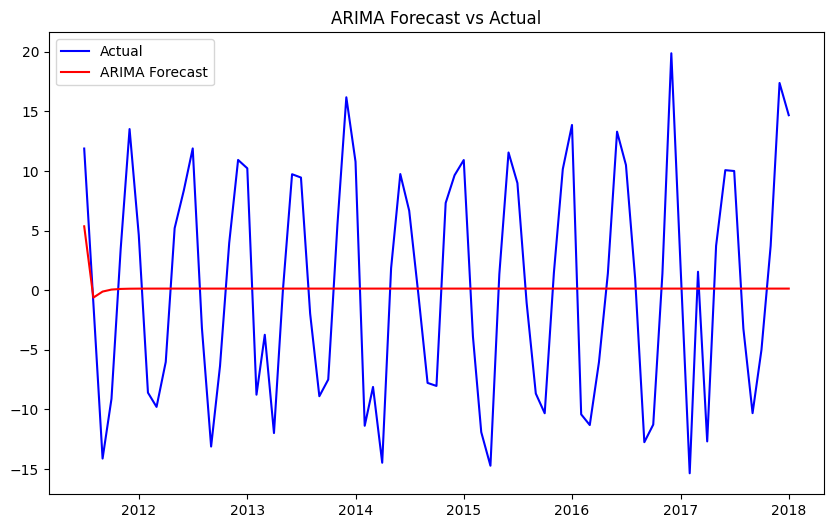

In [33]:

# Fit ARIMA model with parameters from AutoARIMA
arima_model = ARIMA(train_arima, order=(p, d, q))
arima_fit = arima_model.fit()

# Forecast the future values
arima_forecast = arima_fit.forecast(steps=len(test_arima))

# Plot the forecasted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(test_arima.index, test_arima, label='Actual', color='blue')
plt.plot(test_arima.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

#### 3.5.1 Restoring Differenced Data & Visualizing the Forecast

In this section, we restore the differenced series back to the original scale:

1. **Restoring the Training Data**: 
   The training data is restored by cumulatively summing the differenced values and adding the first value from the original series.
   
2. **Restoring the Test Data**: 
   Similarly, the test data is restored by adding the last value of the restored training set to the differenced test series.
   
3. **Restoring ARIMA Forecasts**: 
   We also restore the ARIMA model’s forecast to the original scale using the same process.

4. **Visualization**: 
   A comparison plot is generated showing the original data, restored training and test sets, and the ARIMA forecast. This allows us to visually assess how well the model forecasts the actual data.


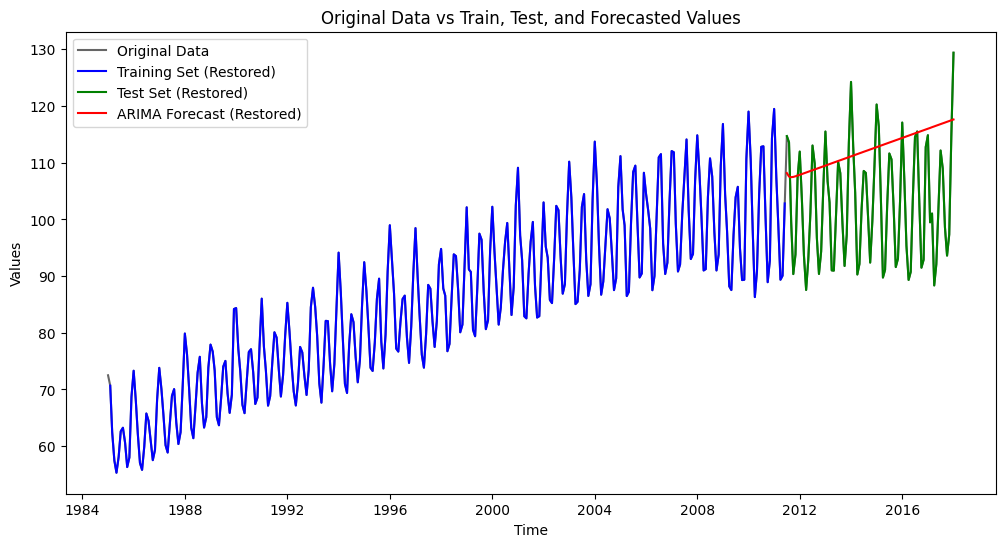

In [35]:


# Restore the differenced training data to original scale
train_arima_original = df.iloc[:len(train_arima)].iloc[0] + train_arima.cumsum()

# Restore the differenced test data to original scale
test_arima_original = train_arima_original.iloc[-1] + test_arima.cumsum()

# Restore the ARIMA forecast to original scale
arima_forecast_original = train_arima_original.iloc[-1] + arima_forecast.cumsum()

# Plot the full dataset vs restored training, test, and forecasted values
plt.figure(figsize=(12, 6))

plt.plot(df.index, df, label='Original Data', color='black', alpha=0.6)  # Full original dataset
plt.plot(train_arima_original.index, train_arima_original, label='Training Set (Restored)', color='blue')
plt.plot(test_arima_original.index, test_arima_original, label='Test Set (Restored)', color='green')
plt.plot(test_arima_original.index, arima_forecast_original, label='ARIMA Forecast (Restored)', color='red')

plt.legend()
plt.title('Original Data vs Train, Test, and Forecasted Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

#### 3.5.2 Forecasting Future Values with ARIMA

In this section, we forecast the next 24 months (2 years) of electricity production using the trained ARIMA model:

1. **Forecasting**: 
   We predict the future values using the ARIMA model for the next 24 months. The forecasted values are then restored to the original scale by cumulatively summing the differenced forecasts and adding the last known actual value.
   
2. **Date Range**: 
   A monthly date range is created for the next 24 months, and the forecasted values are assigned to this range.
   
3. **Visualization**: 
   The original data is plotted alongside the 2-year forecast to visually assess the model's future predictions.

This helps us visualize how well the ARIMA model extrapolates future trends based on historical data.


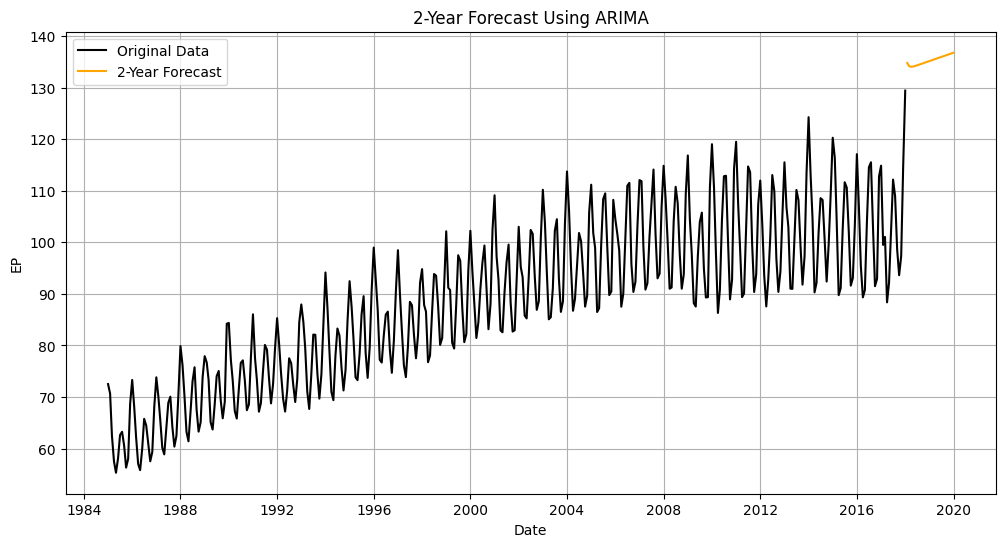

In [37]:

# Forecast next 24 months (2 years)
forecast_steps = 24
future_forecast_diff = arima_fit.forecast(steps=forecast_steps)

# Get the last actual value from the original data (not differenced)
last_actual = df.iloc[-1]

# Restore forecast by cumulative summing and adding the last known actual
future_forecast = last_actual + future_forecast_diff.cumsum()
# Create monthly date range for the next 24 months
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
future_forecast.index = future_dates
plt.figure(figsize=(12, 6))

plt.plot(df.index, df, label='Original Data', color='black')
plt.plot(future_forecast.index, future_forecast, label='2-Year Forecast', color='orange')

plt.title('2-Year Forecast Using ARIMA')
plt.xlabel('Date')
plt.ylabel('EP')
plt.legend()
plt.grid(True)
plt.show()


### 3.6 SARIMA Model: Forecasting and Evaluation

In this section, we fit and evaluate the **SARIMA model**:

1. **Fit the SARIMA Model**: 
   We use the parameters obtained from Auto ARIMA to fit a SARIMA model on the training data. The SARIMA model is capable of capturing both trend and seasonality in the data.
   
2. **Forecast Future Values**: 
   We use the fitted SARIMA model to forecast the future values on the test dataset.

3. **Plot the Forecast vs. Actual**: 
   We compare the actual values in the test dataset with the SARIMA forecast to visually assess the model's performance.

This helps us understand how the SARIMA model performs in capturing the seasonality and trend in the data.


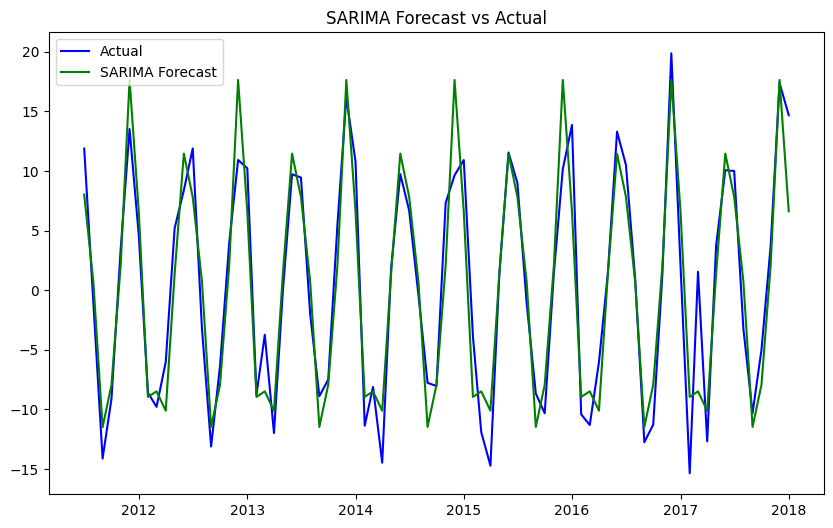

In [39]:

# Fit SARIMA model with parameters from AutoARIMA
sarima_model = SARIMAX(train_arima,
                       order=(p,d, q),  # Non-seasonal ARIMA parameters
                       seasonal_order=(P, D, Q, s))  # Seasonal parameters (P, D, Q, s)

sarima_fit = sarima_model.fit(disp=False)

# Forecast the future values
sarima_forecast = sarima_fit.forecast(steps=len(test_arima))

# Plot the forecasted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(test_arima.index, test_arima, label='Actual', color='blue')
plt.plot(test_arima.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.show()


#### 3.6.1 Restoring SARIMA Forecast and Visualizing the Results

In this section, we restore the **SARIMA forecast** to the original scale and compare it with the original data:

1. **Restoring the SARIMA Forecast**: 
   The SARIMA forecast is restored to the original scale by cumulatively summing the forecasted values and adding the last known actual value from the training set.

2. **Visualization**: 
   We plot the **original data**, **restored training data**, **restored test data**, and the **SARIMA forecast**. This allows us to visually assess how well the SARIMA model fits the historical data and its forecast accuracy.

This comparison helps us understand the SARIMA model's ability to capture the underlying trends and seasonality in the data.


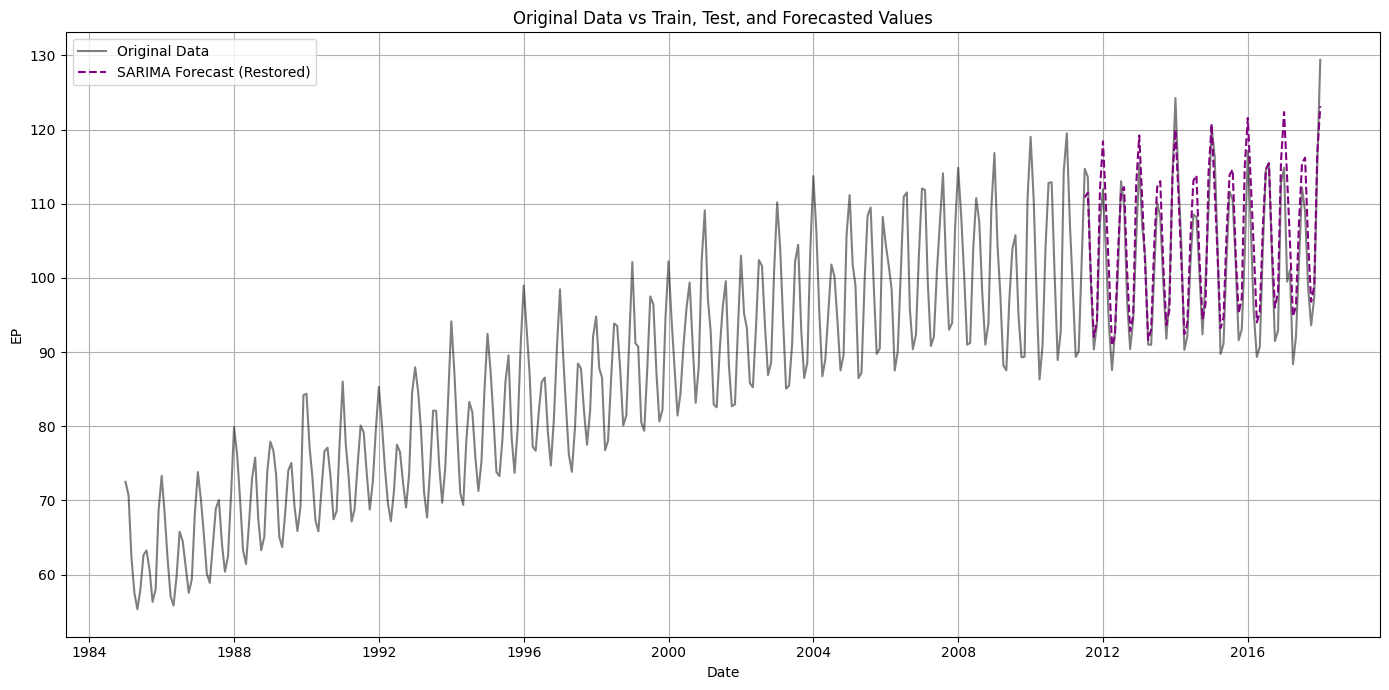

In [41]:
sarima_forecast_original = train_arima_original.iloc[-1] + sarima_forecast.cumsum()
plt.figure(figsize=(14, 7))

# Original time series
plt.plot(df.index, df, label='Original Data', color='black', alpha=0.5)



# Restored SARIMA forecasts
plt.plot(test_arima_original.index, sarima_forecast_original, label='SARIMA Forecast (Restored)', color='purple', linestyle='--')

plt.title('Original Data vs Train, Test, and Forecasted Values')
plt.xlabel('Date')
plt.ylabel('EP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 3.6.2 SARIMA: Historical Data vs. 2-Year Forecast

In this section, we forecast the next 24 months (2 years) of electricity production using the **SARIMA model**:

1. **Forecasting Future Values**: 
   The SARIMA model is used to predict future values for the next 24 months. The forecasted values are restored to the original scale by cumulatively summing the differenced forecast and adding the last actual value from the original time series.

2. **Date Range**: 
   A new date range for the next 24 months is created, and the forecasted values are assigned to this range.

3. **Visualization**: 
   We plot the **original data** along with the **future SARIMA forecast** for the next 2 years, using a dashed line to show the forecasted values.

This helps in understanding the SARIMA model’s prediction for future trends in electricity production, visualizing the forecast against historical data.


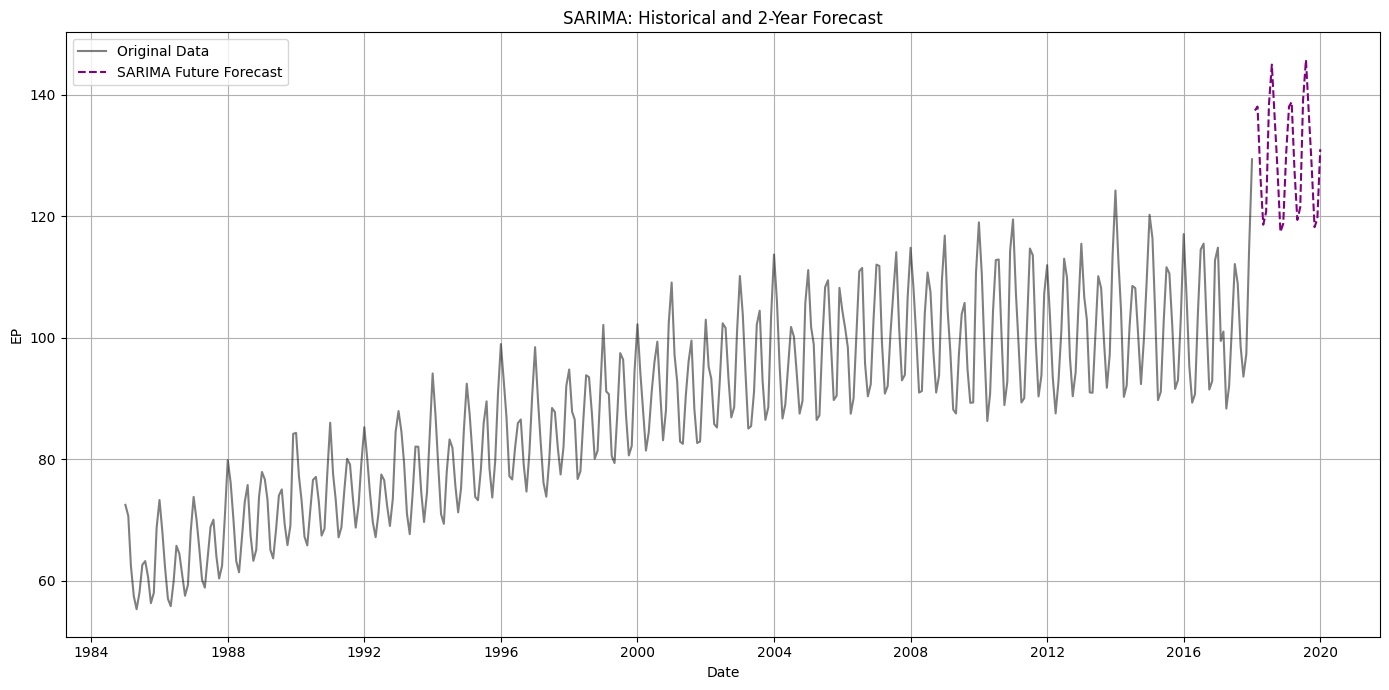

In [43]:
future_steps = 24  # 2 years of monthly data
sarima_future_diff = sarima_fit.forecast(steps=future_steps)
# Start from the last value of the original time series
last_value_sarima = df.iloc[-1]
sarima_future = last_value_sarima + sarima_future_diff.cumsum()
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')
sarima_future.index = future_dates
plt.figure(figsize=(14, 7))

# Plot original series
plt.plot(df.index, df, label='Original Data', color='black', alpha=0.5)

# Future SARIMA forecast
plt.plot(sarima_future.index, sarima_future, label='SARIMA Future Forecast', color='purple', linestyle='--')


plt.title('SARIMA: Historical and 2-Year Forecast')
plt.xlabel('Date')
plt.ylabel('EP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 4 Model 2: Regression-Based

In this section, we explore a regression-based approach to modeling the time series data. We use **Linear Regression** for trend modeling, **Polynomial Regression** for capturing nonlinear trends, and **Feature Importance** analysis to evaluate the significance of the features.

####  Linear Regression (Trend Modeling)
Linear regression is used to capture the overall trend in the data by fitting a straight line. This approach assumes that the relationship between the target variable (electricity production) and time is linear.

####  Polynomial Regression (Nonlinear Trends)
Polynomial regression is employed to model nonlinear trends in the data. By using higher-degree polynomials, this model can better capture complex patterns and fluctuations in the data.

####  Feature Importance (Coefficient Analysis)
We analyze the coefficients of the linear and polynomial regression models to assess the importance of different features. This helps us understand the influence of various time-based features (like Month, Year, and TimeIndex) on the target variable (electricity production).

This regression-based approach provides insights into both linear and nonlinear trends and allows for deeper interpretation of the features driving the data.


### 4.1 Linear Regression (Trend Modeling)

In this section, we apply **Linear Regression** to model the trend in the electricity production data:

1. **Lag Features Generation**: 
   Lag features are generated to capture the relationship between previous months' electricity production values and the target variable (current month's electricity production). We create 12 lag features, each representing the electricity production value from the previous 1 to 12 months.

2. **Train-Test Split**: 
   The data is split into a training set (75%) and a test set (25%). The features used in the regression model include time-based variables like the **TimeIndex**, **Month**, **Quarter**, and **Month_sin**, **Month_cos**, along with the generated **lag features**. The target variable is the electricity production (**EP**).

3. **Model Fitting**: 
   We fit a **Linear Regression** model on the training data to learn the relationship between the features and the target variable.

4. **Prediction and Evaluation**: 
   After fitting the model, we predict the electricity production on the test set and visualize the **Actual vs Predicted** values. Additionally, we plot the **residuals** (the difference between the actual and predicted values) over time to check the model's accuracy and any patterns in the residuals.

This process allows us to examine how well a simple linear model can capture trends in the data and how the model performs with lag-based features.


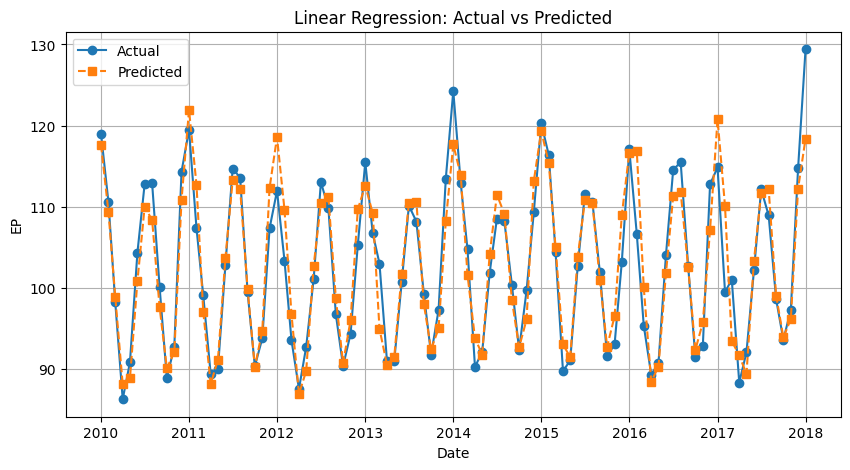

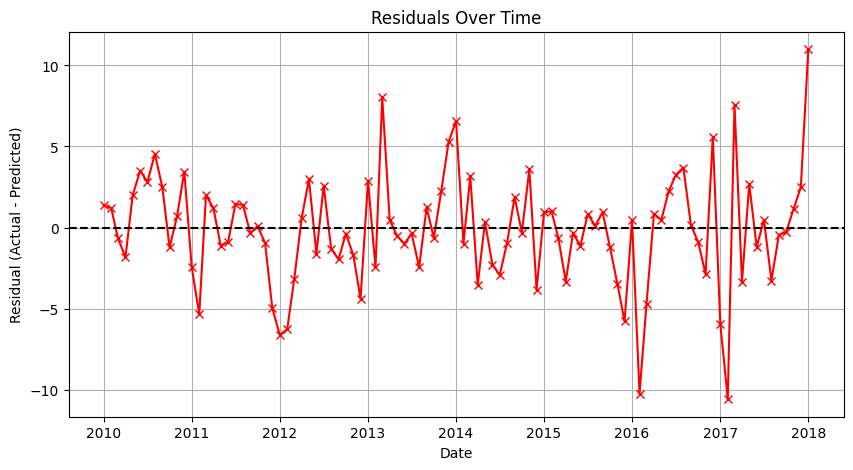

In [46]:
# Generate lag features before splitting
for lag in range(1, 13):  # 12 months
    df_reg[f'EP_lag_{lag}'] = df_reg['EP'].shift(lag)
# Drop NaN values (first 12 rows will have missing values)
df_reg.dropna(inplace=True)
# Proceed with train-test split
train_size = int(len(df_reg) * 0.75)
train_reg = df_reg.iloc[:train_size]
test_reg = df_reg.iloc[train_size:]
# Define features (include lag variables now)
features = ['TimeIndex', 'Month',
            'Quarter', 'Month_sin', 
            'Month_cos']+ [f'EP_lag_{lag}' for lag in range(1, 13)]

target = 'EP'
# Prepare training and testing sets
X_train = train_reg[features]
y_train = train_reg[target]
X_test = test_reg[features]
y_test = test_reg[target]

# Fit the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = lin_reg.predict(X_test)


plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', marker='o', linestyle='-')
plt.plot(y_test.index, y_pred, label='Predicted', marker='s', linestyle='--')
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("EP")
plt.legend()
plt.grid(True)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, residuals, marker='x', linestyle='-', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.show()


#### 4.1.1 Linear Regression Forecast: Future Predictions

After training the Linear Regression model, we use it to predict future values for the next 2 years (24 months). The following steps are performed to generate the forecast:

1. **Future Feature Generation**:
   A new DataFrame is created to hold the features for future dates (next 24 months). These features include:
   - **TimeIndex**: A sequential index representing the time step.
   - **Month, Quarter, Month_sin, and Month_cos**: Time-based features, including cyclical encoding of months.
   
2. **Lag Feature Creation**:
   The last 12 months of actual electricity production values are used to create lag features, which are essential for generating the predictions. For each future time step, the lag features are dynamically updated based on previous predictions, allowing the model to forecast the next month.

3. **Prediction**:
   The Linear Regression model predicts the future electricity production for each time step using the newly generated features and lag values. The predictions are appended to the list of lag values for future time steps.

4. **Visualization**:
   The forecasted values for the next 2 years are plotted alongside the original data to visualize the model's predictions.

This method allows us to extend the linear regression model into the future while incorporating time-based patterns and lag features into the predictions.


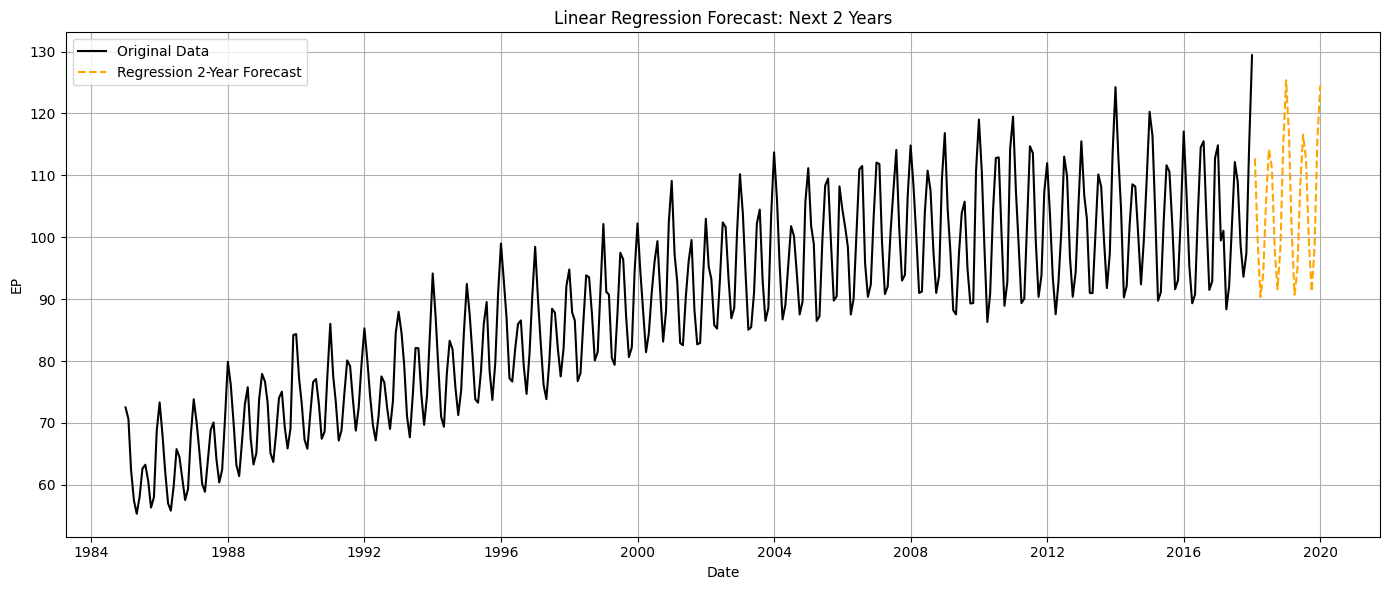

In [48]:
last_date = df_reg.index[-1]
last_time_index = df_reg['TimeIndex'].iloc[-1]
future_steps = 24
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# Create a DataFrame for future features
future_df = pd.DataFrame(index=future_dates)
future_df['TimeIndex'] = range(last_time_index + 1, last_time_index + future_steps + 1)
future_df['Month'] = future_df.index.month
future_df['Quarter'] = future_df.index.quarter
future_df['Month_sin'] = np.sin(2 * np.pi * future_df['Month'] / 12)
future_df['Month_cos'] = np.cos(2 * np.pi * future_df['Month'] / 12)
# Get last 12 months of actual EP values
last_12_ep = df_reg['EP'].iloc[-12:].values.tolist()

# For each future row, generate lags based on previous predictions
future_ep = []

for i in range(future_steps):
    lag_features = last_12_ep[-12:]  # Take the last 12 values
    feature_row = {
        'TimeIndex': future_df['TimeIndex'].iloc[i],
        'Month': future_df['Month'].iloc[i],
        'Quarter': future_df['Quarter'].iloc[i],
        'Month_sin': future_df['Month_sin'].iloc[i],
        'Month_cos': future_df['Month_cos'].iloc[i]
    }
    for j in range(12):
        feature_row[f'EP_lag_{j+1}'] = lag_features[-(j+1)]
    # Convert to DataFrame
    X_future = pd.DataFrame([feature_row])
    pred = lin_reg.predict(X_future)[0]
    future_ep.append(pred)
    last_12_ep.append(pred)  # Append prediction to the list for future lags
future_forecast_reg = pd.Series(future_ep, index=future_dates)
plt.figure(figsize=(14, 6))
plt.plot(df.index, df, label='Original Data', color='black')
plt.plot(future_forecast_reg.index, future_forecast_reg, label='Regression 2-Year Forecast', color='orange', linestyle='--')

plt.title('Linear Regression Forecast: Next 2 Years')
plt.xlabel('Date')
plt.ylabel('EP')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 4.2 Polynomial Regression Forecast: Nonlinear Trend Modeling

In addition to Linear Regression, we also implement **Polynomial Regression** to capture potential nonlinear trends in the electricity production data. This model allows for the modeling of more complex relationships between the features and the target variable.

1. **Feature and Target Separation**:
   - The features are derived from time-based encoding (e.g., Month, Quarter) and lag values.
   - The target variable is electricity production (`EP`), which is used to train the model.

2. **Polynomial Regression Model**:
   - **Degree 2 Polynomial Features**: We use polynomial features of degree 2 (quadratic) to capture nonlinear patterns in the data.
   - A **pipeline** is created that includes both the polynomial feature transformation and the Linear Regression model.

3. **Model Fitting**:
   - The pipeline is fitted on the training data to learn the nonlinear relationships in the time series.

4. **Prediction and Visualization**:
   - Predictions are made using the fitted model on the test set.
   - The actual vs predicted values are plotted to visualize how well the polynomial regression captures the trends in the data.
   - **Residuals** (differences between actual and predicted values) are plotted to assess the model's accuracy and any remaining patterns in the residuals.

This model helps to account for more complex, curving patterns in the data that a simple linear regression might miss. It allows for a better representation of real-world trends that are often nonlinear.


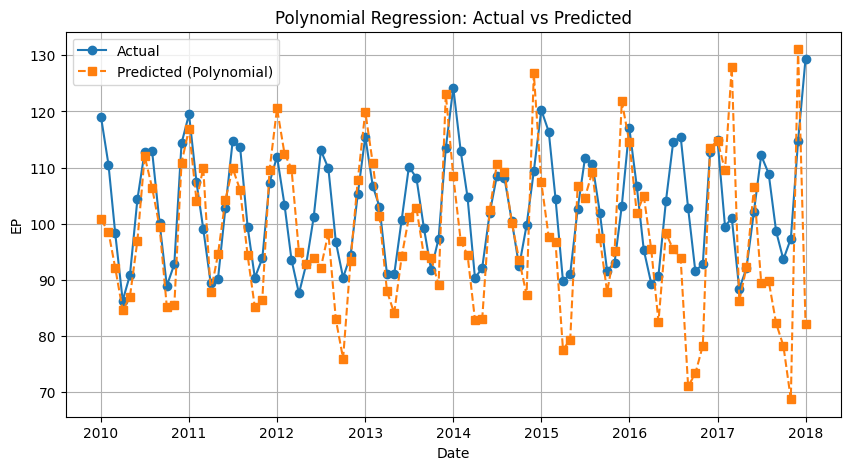

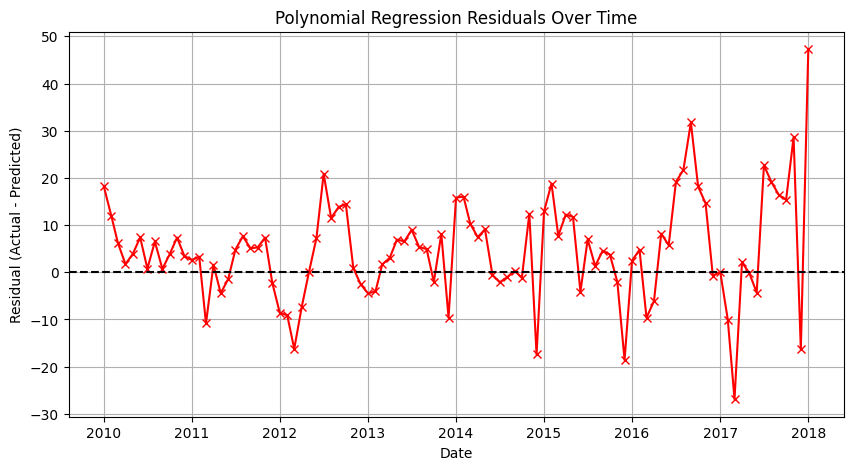

In [50]:

# Separate features and target
X_train = train_reg[features]
X_test = test_reg[features]
y_train = train_reg[df.name]
y_test = test_reg[df.name]
# Create pipeline for polynomial regression (degree 2)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
# Fit the model
poly_model.fit(X_train, y_train)

# Predict
y_pred_poly = poly_model.predict(X_test)


# Create a figure
plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(y_test.index, y_test, label='Actual', marker='o', linestyle='-')

# Plot polynomial regression predictions
plt.plot(y_test.index, y_pred_poly, label='Predicted (Polynomial)', marker='s', linestyle='--')

# Formatting
plt.title("Polynomial Regression: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("EP")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

residuals_poly = y_test - y_pred_poly

plt.figure(figsize=(10, 5))
plt.plot(y_test.index, residuals_poly, marker='x', linestyle='-', color='red')
plt.axhline(0, color='black', linestyle='--')

plt.title("Polynomial Regression Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.show()


### 4.3 Feature Importance: Polynomial Regression Coefficients

We extract and display the coefficients from the polynomial regression pipeline to understand the relative importance of each feature:

1. **Extract Pipeline Steps**  
   - Retrieve the `PolynomialFeatures` transformer and the fitted `LinearRegression` model from the `poly_model` pipeline.

2. **Generate Feature Names**  
   - Use `get_feature_names_out()` on the `PolynomialFeatures` step to obtain the names of all transformed features (including interaction and squared terms).

3. **Build Coefficient DataFrame**  
   - Create a DataFrame mapping each feature name to its corresponding coefficient from the linear regression model.
   - Include the **intercept** as a separate row.

4. **Display Results**  
   - View the combined DataFrame to analyze which features have the strongest positive or negative influence on the target variable (`EP`).


In [52]:
# ---- Polynomial Regression Coefficients Section ----

poly_features = poly_model.named_steps['polynomialfeatures']
poly_reg      = poly_model.named_steps['linearregression']

feature_names = poly_features.get_feature_names_out(input_features=features)

coef_df = pd.DataFrame({
    'Feature':     feature_names,
    'Coefficient': poly_reg.coef_
})

intercept_df = pd.DataFrame([['Intercept', poly_reg.intercept_]],
                            columns=coef_df.columns)

# Concatenate and print
coef_df = pd.concat([intercept_df, coef_df], ignore_index=True)
print(coef_df)


                 Feature   Coefficient
0              Intercept -1.041811e+01
1                      1  3.010144e-08
2              TimeIndex -2.944341e-01
3                  Month  8.014779e+00
4                Quarter -1.744417e+01
..                   ...           ...
167  EP_lag_10 EP_lag_11  4.259485e-02
168  EP_lag_10 EP_lag_12  1.869685e-02
169          EP_lag_11^2 -4.873756e-02
170  EP_lag_11 EP_lag_12  1.068598e-02
171          EP_lag_12^2 -8.651453e-03

[172 rows x 2 columns]



## 5. Model Evaluation: Calculating & Comparing Metrics

1. **Inspect Feature Shapes**  
   Print the shapes of the training and test feature matrices.

2. **Initialize Results Table**  
   Create an empty `results_df` DataFrame to store performance metrics (`MPE`, `MAPE`, `RMSE`, `R²`) for each model.

3. **Helper Function**  
   Define `add_results()` to append a model’s metrics to `results_df`.

4. **Evaluate Each Model**  
   - **ARIMA**: Forecast on the test set, compute metrics, and add to the table.  
   - **SARIMA**: Forecast on the test set, compute metrics, and add to the table.  
   - **Linear Regression**: Predict on the test set, compute metrics, and add to the table.  
   - **Polynomial Regression**: Predict on the test set, compute metrics, and add to the table.  

5. **Display Results**  
   Print `results_df` to compare model performance side by side.


In [54]:
print("Train features:", X_train.shape)
print("Test features:", X_test.shape)
# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Model', 'MPE', 'MAPE', 'RMSE', 'R²'])

# Function to add model results to the table
def add_results(model_name, mpe, mape, rmse, r2):
    global results_df
    new_row = pd.DataFrame({
        'Model': [model_name],
        'MPE': [mpe],
        'MAPE': [mape],
        'RMSE': [rmse],
        'R²': [r2]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# ---- ARIMA Evaluation ----
arima_forecast = arima_fit.forecast(steps=len(test_arima))

# ARIMA Metrics
mpe_arima = np.mean((test_arima - arima_forecast) / test_arima) * 100
mape_arima = mean_absolute_percentage_error(test_arima, arima_forecast) * 100
rmse_arima = np.sqrt(mean_squared_error(test_arima, arima_forecast))
r2_arima = r2_score(test_arima, arima_forecast)

# Add ARIMA results to the table
add_results("ARIMA", mpe_arima, mape_arima, rmse_arima, r2_arima)

# ---- SARIMA Evaluation ----
sarima_forecast = sarima_fit.forecast(steps=len(test_arima))

# SARIMA Metrics
mpe_sarima = np.mean((test_arima - sarima_forecast) / test_arima) * 100
mape_sarima = mean_absolute_percentage_error(test_arima, sarima_forecast) * 100
rmse_sarima = np.sqrt(mean_squared_error(test_arima, sarima_forecast))
r2_sarima = r2_score(test_arima, sarima_forecast)

# Add SARIMA results to the table
add_results("SARIMA", mpe_sarima, mape_sarima, rmse_sarima, r2_sarima)

# ---- Linear Regression Evaluation ----
y_pred_linear = lin_reg.predict(X_test)

# Linear Regression Metrics
mpe_linear = np.mean((y_test - y_pred_linear) / y_test) * 100
mape_linear = mean_absolute_percentage_error(y_test, y_pred_linear) * 100
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)

# Add Linear Regression results to the table
add_results("Linear Regression", mpe_linear, mape_linear, rmse_linear, r2_linear)

# ---- Polynomial Regression Evaluation ----
y_pred_poly = poly_model.predict(X_test)

# Polynomial Regression Metrics
mpe_poly = np.mean((y_test - y_pred_poly) / y_test) * 100
mape_poly = mean_absolute_percentage_error(y_test, y_pred_poly) * 100
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

# Add Polynomial Regression results to the table
add_results("Polynomial Regression", mpe_poly, mape_poly, rmse_poly, r2_poly)

# ---- Display the Evaluation Table ----
print(results_df)


Train features: (288, 17)
Test features: (97, 17)
                   Model         MPE        MAPE       RMSE        R²
0                  ARIMA  102.274119  102.274119   9.383201  0.014424
1                 SARIMA   58.693299   92.363738   3.448963  0.866843
2      Linear Regression   -0.204331    2.412352   3.431795  0.878058
3  Polynomial Regression    4.375053    8.500207  11.899695 -0.466167


---